In [166]:
import torch.nn.functional as f
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [167]:
class MyCnn(nn.Module):
    def __init__(self, num_classes=10):
        super(MyCnn, self).__init__()
        self.features = nn.Sequential(
            # kernel_size:畳み込む行列のサイズ
            # stride:スライドするときのサイズ
            # padding:上下左右に追加する空白
            # 1*28*28 のデータ
            nn.Conv2d(1, 64, kernel_size=2, stride=1, padding=1), # 1*28*28 => 64*29*29
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1), #64*29*29 => 64*27*27 46656
            nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1), # 64*27*27 => 192*27*27 139968
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=3), # 192*27*27 => 192*9*9 15552
            nn.Conv2d(192, 384, kernel_size=2, stride=1, padding=1), # 192*9*9 => 384*10*10
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1), # 384*10*10 => 256*10*10
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1), # 256*10*10 => 256*10*10
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 256*10*10 => 256*5*5
        )
            
        self.classifier = nn.Linear(256*5*5, 10)
#         self.classifier = nn.Linear(28*28, 10)
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [168]:
def load_MNIST(batch=128, intensity=1.0):
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=True,
                       download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data',
                       train=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x * intensity)
                       ])),
        batch_size=batch,
        shuffle=True)
 
    return {'train': train_loader, 'test': test_loader}

In [169]:
class ZeroDLCnn(nn.Module):
    def __init__(self, num_classes=10):
        super(ZeroDLCnn, self).__init__()
        self.features = nn.Sequential(
            # kernel_size:畳み込む行列のサイズ
            # stride:スライドするときのサイズ
            # padding:上下左右に追加する空白
            # 1*28*28 のデータ
            nn.Conv2d(1, 30, kernel_size=5, stride=1, padding=0), # 1*28*28 => 30*24*24
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #30*24*24 => 30*12*12
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(30*12*12, 30*12*12),
            nn.ReLU(inplace=True),
            nn.Linear(30*12*12, 10),
            nn.Softmax()
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [173]:
num_epoch = 2
history = {
    'train_loss':[],
    'test_loss':[],
    'test_acc':[]
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = ZeroDLCnn().to(device)
loaders = load_MNIST()
optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

In [174]:
for i_epoch in range(num_epoch):
    loss = None
    
    net.train(True)
    
    criterion = nn.CrossEntropyLoss()
    
    for i, (data, target) in enumerate(loaders['train']):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        output = net(data)
        
#         print(output.shape)
        
#         loss = f.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('Training log: {} epoch ({} / 60000 train. data). Loss: {}'.format(i_epoch+1, (i+1)*128, loss.item()))
    
    history['train_loss'].append(loss)
    
    net.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loaders['test']:
            data = data.to(device)
            target = target.to(device)
            
            output = net(data)
            test_loss += f.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= 10000
    print('Test loss (avg): {}, Accuracy: {}'.format(test_loss, correct / 10000))
    
    history['test_loss'].append(test_loss)
    history['test_acc'].append(correct / 10000)

C:\Users\Keisuke Toyoda\anaconda3\lib\site-packages\torch\nn\modules\container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training log: 1 epoch (128 / 60000 train. data). Loss: 2.302431106567383
Training log: 1 epoch (1408 / 60000 train. data). Loss: 1.7706427574157715
Training log: 1 epoch (2688 / 60000 train. data). Loss: 1.6010228395462036
Training log: 1 epoch (3968 / 60000 train. data). Loss: 1.5828520059585571
Training log: 1 epoch (5248 / 60000 train. data). Loss: 1.567144751548767
Training log: 1 epoch (6528 / 60000 train. data). Loss: 1.6042959690093994
Training log: 1 epoch (7808 / 60000 train. data). Loss: 1.6281126737594604
Training log: 1 epoch (9088 / 60000 train. data). Loss: 1.5679365396499634
Training log: 1 epoch (10368 / 60000 train. data). Loss: 1.5023746490478516
Training log: 1 epoch (11648 / 60000 train. data). Loss: 1.5734895467758179
Training log: 1 epoch (12928 / 60000 train. data). Loss: 1.536359429359436
Training log: 1 epoch (14208 / 60000 train. data). Loss: 1.4820009469985962
Training log: 1 epoch (15488 / 60000 train. data). Loss: 1.5568984746932983
Training log: 1 epoch (1

TypeError: forward() got an unexpected keyword argument 'reduction'

{'train_loss': [tensor(1.4809, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4831, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4969, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4692, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4770, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4619, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4734, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4612, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4612, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.4612, device='cuda:0', grad_fn=<NllLossBackward>)], 'test_loss': [-0.9723451945304871, -0.9801469521522522, -0.9788562504768371, -0.9855722445487977, -0.9858137870788575, -0.9864324729919434, -0.985899491405487, -0.9866091459274292, -0.9861304107666016, -0.9891011810302734], 'test_acc': [0.9742, 0.9815, 0.9796, 0.9861, 0.9865, 0.9869, 0.986, 0.9871, 0.9867, 0.9892]}


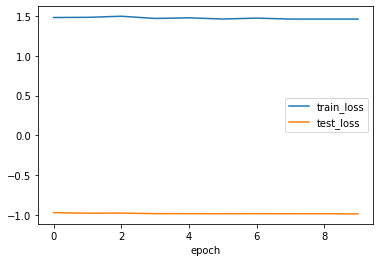

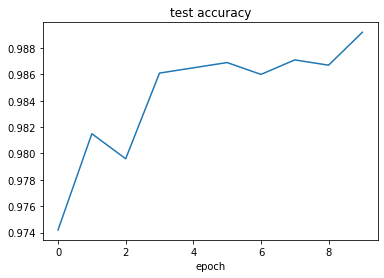

In [172]:
num_epoch
print(history)
plt.figure()
plt.plot(range(len(history['train_loss'])), history['train_loss'], label='train_loss')
plt.plot(range(len(history['test_loss'])), history['test_loss'], label='test_loss')
plt.xlabel('epoch')
plt.legend()
plt.savefig('cnnloss.png')

plt.figure()
plt.plot(range(len(history['test_acc'])), history['test_acc'])
plt.title('test accuracy')
plt.xlabel('epoch')
plt.savefig('cnn_test_acc2.png')